## 1. Configuración Inicial

In [3]:
# ================================================
# Imports y Configuración
# ================================================
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings

# Configuración de visualización
warnings.filterwarnings('ignore') # Ignorar advertencias
plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráficos
plt.rcParams['figure.figsize'] = (12, 6) # Tamaño de las figuras
plt.rcParams['font.size'] = 10 #Tamaño de la fuente en los gráficos
pd.set_option('display.max_columns', None) # Mostrar todas las columnas
pd.set_option('display.max_rows', 100) # Mostrar hasta 100 filas
pd.set_option('display.float_format', '{:.4f}'.format) # Formato números flotantes, notación científica desactivada

# Rutas del proyecto
PROJECT_ROOT = Path.cwd().parent # Asumiendo que el script está en una carpeta dentro del proyecto
DATA_PATH = PROJECT_ROOT / 'data' / 'trading_data.db' # Ruta a la base de datos
REPORTS_PATH = PROJECT_ROOT / 'reports' # Ruta a la carpeta de reportes
FIGURES_PATH = REPORTS_PATH / 'figures' # Ruta a la carpeta de figuras

# Crear carpetas si no existen
REPORTS_PATH.mkdir(exist_ok=True)
FIGURES_PATH.mkdir(exist_ok=True)

print(f"📁 Proyecto: {PROJECT_ROOT}")
print(f"📊 Base de datos: {DATA_PATH}")
print(f"✅ Archivo existe: {DATA_PATH.exists()}")

📁 Proyecto: c:\Users\carlo\Documents\4.DS\riskmanagement2025
📊 Base de datos: c:\Users\carlo\Documents\4.DS\riskmanagement2025\data\trading_data.db
✅ Archivo existe: True


## 2. Conexión a Base de Datos SQLite

In [4]:
# ================================================
# Conexión a la base de datos
# ================================================
conn = sqlite3.connect(DATA_PATH) # Conexión a la base de datos SQLite
print("✅ Conexión establecida exitosamente")

# Listar tablas disponibles
tables_query = "SELECT name FROM sqlite_master WHERE type='table'" # Consulta para obtener nombres de tablas
tables = pd.read_sql(tables_query, conn) # Ejecutar consulta y cargar en DataFrame

print(f"\n📋 Tablas disponibles en la base de datos:")
print("=" * 40)
for i, table in enumerate(tables['name'], 1): # Enumerar y mostrar tablas
    print(f"  {i}. {table}")

✅ Conexión establecida exitosamente

📋 Tablas disponibles en la base de datos:
  1. prices_daily
  2. universe


## 3. Exploración de Estructura de Tablas

In [5]:
# ================================================
# Explorar estructura de cada tabla
# ================================================
for table_name in tables['name']:
    print(f"\n{'='*60}")
    print(f"📊 TABLA: {table_name}")
    print("=" * 60)
    
    # Información de columnas
    columns_info = pd.read_sql(f"PRAGMA table_info({table_name})", conn)
    print("\n📌 Estructura de columnas:")
    print(columns_info[['name', 'type', 'notnull', 'pk']].to_string(index=False))
    
    # Muestra de datos
    sample = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 5", conn)
    print(f"\n📝 Primeras 5 filas:")
    display(sample)
    
    # Conteo de registros
    count = pd.read_sql(f"SELECT COUNT(*) as total FROM {table_name}", conn).iloc[0, 0]
    print(f"\n📊 Total de registros: {count:,}")


📊 TABLA: prices_daily

📌 Estructura de columnas:
      name      type  notnull  pk
      date      TEXT        1   1
    symbol      TEXT        1   2
      open      REAL        0   0
      high      REAL        0   0
       low      REAL        0   0
     close      REAL        0   0
 adj_close      REAL        0   0
    volume   INTEGER        0   0
asset_type      TEXT        0   0
    source      TEXT        0   0
created_at TIMESTAMP        0   0

📝 Primeras 5 filas:


,date,symbol,open,high,low,close,adj_close,volume,asset_type,source,created_at
0,2010-12-27,SPY,125.1300,125.7700,125.0400,125.6500,125.6500,48008700,ETF,interactive_brokers,2025-12-19 19:07:28
1,2010-12-28,SPY,125.8900,125.9500,125.5000,125.8000,125.8000,47261100,ETF,interactive_brokers,2025-12-19 19:07:28
2,2010-12-29,SPY,125.9800,126.2000,125.9000,125.9200,125.9200,45302100,ETF,interactive_brokers,2025-12-19 19:07:28
3,2010-12-30,SPY,125.7900,126.1300,125.5300,125.7200,125.7200,58592700,ETF,interactive_brokers,2025-12-19 19:07:28
4,2010-12-31,SPY,125.5100,125.8700,125.3300,125.7800,125.7800,68305100,ETF,interactive_brokers,2025-12-19 19:07:28



📊 Total de registros: 1,694,523

📊 TABLA: universe

📌 Estructura de columnas:
         name      type  notnull  pk
       symbol      TEXT        0   1
   asset_type      TEXT        0   0
     exchange      TEXT        0   0
     currency      TEXT        0   0
   first_date      TEXT        0   0
    last_date      TEXT        0   0
total_records   INTEGER        0   0
   created_at TIMESTAMP        0   0

📝 Primeras 5 filas:


,symbol,asset_type,exchange,currency,first_date,last_date,total_records,created_at
0,SPY,ETF,SMART,USD,2010-12-27,2025-12-19,3770,2025-12-19 19:07:28
1,QQQ,ETF,SMART,USD,2010-12-23,2025-12-19,3771,2025-12-19 19:07:32
2,DIA,ETF,SMART,USD,2010-12-27,2025-12-19,3770,2025-12-19 19:07:38
3,IWM,ETF,SMART,USD,2010-12-27,2025-12-19,3770,2025-12-19 19:07:41
4,VTI,ETF,SMART,USD,2010-12-27,2025-12-19,3770,2025-12-19 19:07:45



📊 Total de registros: 471


In [6]:
# ================================================
# Identificar tabla principal de precios
# ================================================
price_table = None
for table_name in tables['name']:
    cols = pd.read_sql(f"PRAGMA table_info({table_name})", conn)['name'].str.lower().tolist()
    # Buscar columnas típicas de precios
    if any(c in cols for c in ['close', 'adj_close', 'adjclose', 'price']):
        price_table = table_name
        print(f"✅ Tabla de precios identificada: {price_table}")
        break

if price_table is None:
    print("⚠️ No se identificó tabla de precios automáticamente.")
    print("Por favor, revisa las tablas disponibles y asigna manualmente:")
    # Descomentar y ajustar:
    # price_table = 'nombre_de_tu_tabla'

✅ Tabla de precios identificada: prices_daily


In [8]:
# ================================================
# Cargar datos de precios completos
# ================================================
print(f"⏳ Cargando datos de la tabla '{price_table}'...")

df_prices = pd.read_sql(f"SELECT * FROM {price_table}", conn) # Cargar datos de precios a un df de Python (Pandas)

print(f"\n✅ Datos cargados exitosamente")
print(f"   📊 Dimensiones: {df_prices.shape[0]:,} filas x {df_prices.shape[1]} columnas")
print(f"   📋 Columnas: {list(df_prices.columns)}")

print(df_prices.head(10))

⏳ Cargando datos de la tabla 'prices_daily'...

✅ Datos cargados exitosamente
   📊 Dimensiones: 1,694,523 filas x 11 columnas
   📋 Columnas: ['date', 'symbol', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'asset_type', 'source', 'created_at']
         date symbol     open     high      low    close  adj_close  \
0  2010-12-27    SPY 125.1300 125.7700 125.0400 125.6500   125.6500   
1  2010-12-28    SPY 125.8900 125.9500 125.5000 125.8000   125.8000   
2  2010-12-29    SPY 125.9800 126.2000 125.9000 125.9200   125.9200   
3  2010-12-30    SPY 125.7900 126.1300 125.5300 125.7200   125.7200   
4  2010-12-31    SPY 125.5100 125.8700 125.3300 125.7800   125.7800   
5  2011-01-03    SPY 126.7100 127.6000 126.6600 127.0100   127.0100   
6  2011-01-04    SPY 127.3300 127.3700 126.1900 126.9300   126.9300   
7  2011-01-05    SPY 126.5700 127.7200 126.4600 127.6400   127.6400   
8  2011-01-06    SPY 127.6900 127.8300 127.0100 127.3900   127.3900   
9  2011-01-07    SPY 127.5600 127.770

In [9]:
# ================================================
# Identificar nombres de columnas clave (Para identificar si tenemos las columnas necesarias)
# ================================================
# Normalizar nombres de columnas a minúsculas para búsqueda
col_mapping = {c.lower(): c for c in df_prices.columns}

# Buscar columna de fecha
date_candidates = ['date', 'fecha', 'datetime', 'timestamp', 'time']
DATE_COL = None
for candidate in date_candidates:
    if candidate in col_mapping:
        DATE_COL = col_mapping[candidate]
        break

# Buscar columna de ticker (símbolo o nombre del activo)
ticker_candidates = ['ticker', 'symbol', 'simbolo', 'asset', 'activo', 'stock']
TICKER_COL = None
for candidate in ticker_candidates:
    if candidate in col_mapping:
        TICKER_COL = col_mapping[candidate]
        break

# Buscar columna de precio ajustado
price_candidates = ['adj_close', 'adjclose', 'adjusted_close', 'adj close', 'close']
PRICE_COL = None
for candidate in price_candidates:
    if candidate in col_mapping:
        PRICE_COL = col_mapping[candidate]
        break

# Buscar columna de volumen (cantidad negociada)
volume_candidates = ['volume', 'volumen', 'vol']
VOLUME_COL = None
for candidate in volume_candidates:
    if candidate in col_mapping:
        VOLUME_COL = col_mapping[candidate]
        break

print("📌 Columnas identificadas:")
print(f"   • Fecha: {DATE_COL}")
print(f"   • Ticker: {TICKER_COL}")
print(f"   • Precio (adj_close): {PRICE_COL}")
print(f"   • Volumen: {VOLUME_COL}")

# Verificar que todas las columnas fueron encontradas
if None in [DATE_COL, TICKER_COL, PRICE_COL]:
    print("\n⚠️ ADVERTENCIA: Algunas columnas no fueron identificadas automáticamente.")
    print("Columnas disponibles:", list(df_prices.columns))
    print("\nPor favor, asigna manualmente las columnas:")
    print("# DATE_COL = 'nombre_columna_fecha'")
    print("# TICKER_COL = 'nombre_columna_ticker'")
    print("# PRICE_COL = 'nombre_columna_precio'")

📌 Columnas identificadas:
   • Fecha: date
   • Ticker: symbol
   • Precio (adj_close): adj_close
   • Volumen: volume


## 4. Análisis de Completitud y Calidad de Datos

In [10]:
# ================================================
# Convertir fecha y ordenar
# ================================================
df_prices[DATE_COL] = pd.to_datetime(df_prices[DATE_COL])
df_prices = df_prices.sort_values([TICKER_COL, DATE_COL]).reset_index(drop=True)

print("📅 Rango de fechas en los datos:")
print(f"   • Fecha mínima: {df_prices[DATE_COL].min()}")
print(f"   • Fecha máxima: {df_prices[DATE_COL].max()}")
print(f"   • Días totales: {(df_prices[DATE_COL].max() - df_prices[DATE_COL].min()).days:,} días")

📅 Rango de fechas en los datos:
   • Fecha mínima: 2010-12-23 00:00:00
   • Fecha máxima: 2025-12-19 00:00:00
   • Días totales: 5,475 días


In [11]:
# ================================================
# Resumen estadístico general
# ================================================
print("📊 Resumen Estadístico del DataFrame:")
print("=" * 60)

# Información general
print(f"\n📋 Información General:")
print(f"   • Total registros: {len(df_prices):,}")
print(f"   • Tickers únicos: {df_prices[TICKER_COL].nunique():,}")
print(f"   • Fechas únicas: {df_prices[DATE_COL].nunique():,}")

# Tipos de datos
print(f"\n📋 Tipos de datos:")
print(df_prices.dtypes)

📊 Resumen Estadístico del DataFrame:

📋 Información General:
   • Total registros: 1,694,523
   • Tickers únicos: 471
   • Fechas únicas: 3,771

📋 Tipos de datos:
date          datetime64[ns]
symbol                object
open                 float64
high                 float64
low                  float64
close                float64
adj_close            float64
volume                 int64
asset_type            object
source                object
created_at            object
dtype: object


In [12]:
# ================================================
# Análisis de valores nulos
# ================================================
print("📊 Análisis de Valores Nulos:")
print("=" * 60)

null_summary = pd.DataFrame({
    'Columna': df_prices.columns,
    'Nulos': df_prices.isnull().sum().values,
    'Porcentaje': (df_prices.isnull().sum() / len(df_prices) * 100).values
})
null_summary['Porcentaje'] = null_summary['Porcentaje'].apply(lambda x: f"{x:.2f}%")

print(null_summary.to_string(index=False))

total_nulls = df_prices.isnull().sum().sum()
print(f"\n📌 Total de valores nulos: {total_nulls:,}")

📊 Análisis de Valores Nulos:
   Columna  Nulos Porcentaje
      date      0      0.00%
    symbol      0      0.00%
      open      0      0.00%
      high      0      0.00%
       low      0      0.00%
     close      0      0.00%
 adj_close    739      0.04%
    volume      0      0.00%
asset_type      0      0.00%
    source      0      0.00%
created_at      0      0.00%

📌 Total de valores nulos: 739


In [13]:
# Crear un código para revisar qué activos tienen valores nulos en la variable adj_close
df_prices[df_prices["adj_close"].isnull()]

,date,symbol,open,high,low,close,adj_close,volume,asset_type,source,created_at
1509770,2011-01-04,VIXY,633120.0000,650800.0000,633120.0000,633840.0000,NaN,1,ETF,interactive_brokers,2025-12-19 19:12:12
1509771,2011-01-05,VIXY,640400.0000,640800.0000,617440.0000,620400.0000,NaN,9,ETF,interactive_brokers,2025-12-19 19:12:12
1509772,2011-01-06,VIXY,618960.0000,629440.0000,614960.0000,623040.0000,NaN,10,ETF,interactive_brokers,2025-12-19 19:12:12
1509773,2011-01-07,VIXY,617920.0000,701040.0000,609440.0000,624080.0000,NaN,5,ETF,interactive_brokers,2025-12-19 19:12:12
1509774,2011-01-10,VIXY,637120.0000,646960.0000,622080.0000,623040.0000,NaN,8,ETF,interactive_brokers,2025-12-19 19:12:12
...,...,...,...,...,...,...,...,...,...,...,...
1510544,2014-02-03,VIXY,53584.0000,57232.0000,52784.0000,56624.0000,NaN,2473,ETF,interactive_brokers,2025-12-19 19:12:12
1510545,2014-02-04,VIXY,55728.0000,56688.0000,54736.0000,55504.0000,NaN,4890,ETF,interactive_brokers,2025-12-19 19:12:12
1510546,2014-02-05,VIXY,56640.0000,59056.0000,56096.0000,57536.0000,NaN,799,ETF,interactive_brokers,2025-12-19 19:12:12
1510547,2014-02-06,VIXY,56880.0000,56880.0000,51792.0000,51792.0000,NaN,697,ETF,interactive_brokers,2025-12-19 19:12:12


In [14]:
# ================================================
# Imputar valores nulos en adj_close usando close
# ================================================
print("⏳ Imputando valores nulos en adj_close...")

# Contar nulos antes de imputación
nulls_before = df_prices["adj_close"].isnull().sum()
print(f"   • Nulos antes de imputación: {nulls_before:,}")

# Identificar tickers afectados
tickers_with_nulls = df_prices[df_prices["adj_close"].isnull()][TICKER_COL].unique()
print(f"   • Tickers afectados: {list(tickers_with_nulls)}")

# Imputar: donde adj_close es nulo, usar el valor de close
df_prices["adj_close"] = df_prices["adj_close"].fillna(df_prices["close"])

# Verificar imputación
nulls_after = df_prices["adj_close"].isnull().sum()
print(f"   • Nulos después de imputación: {nulls_after:,}")
print(f"\n✅ Imputación completada: {nulls_before - nulls_after:,} valores imputados")

# Actualizar PRICE_COL para asegurar consistencia
PRICE_COL = "adj_close"

⏳ Imputando valores nulos en adj_close...
   • Nulos antes de imputación: 739
   • Tickers afectados: ['VIXY']
   • Nulos después de imputación: 0

✅ Imputación completada: 739 valores imputados


In [16]:
df_prices.isnull().sum()

date          0
symbol        0
open          0
high          0
low           0
close         0
adj_close     0
volume        0
asset_type    0
source        0
created_at    0
dtype: int64

In [17]:
# ================================================
# Estadísticas descriptivas de precios
# ================================================
print("📊 Estadísticas Descriptivas de Variables Numéricas:")
print("=" * 60)

# Seleccionar columnas numéricas
numeric_cols = df_prices.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColumnas numéricas: {numeric_cols}")

display(df_prices[numeric_cols].describe())

📊 Estadísticas Descriptivas de Variables Numéricas:

Columnas numéricas: ['open', 'high', 'low', 'close', 'adj_close', 'volume']


,open,high,low,close,adj_close,volume
count,1694523.0000,1694523.0000,1694523.0000,1694523.0000,1694523.0000,1694523.0000
mean,267.2811,272.4234,262.7085,267.1146,267.1146,5874613.8363
std,8161.0888,8386.4144,7976.1961,8157.1829,8157.1829,26374009.2412
min,0.0003,0.0040,0.0003,0.0022,0.0022,0.0000
25%,39.8500,40.2500,39.4300,39.8500,39.8500,663160.5000
50%,69.7300,70.4400,69.0200,69.7500,69.7500,1628801.0000
75%,125.0700,126.3412,123.8000,125.1100,125.1100,4280266.0000
max,999360.0000,1013920.0000,911680.0000,975600.0000,975600.0000,3366384000.0000


In [18]:
# ================================================
# Análisis de completitud por ticker
# ================================================
print("📊 Análisis de Completitud por Ticker:")
print("=" * 60)

ticker_stats = df_prices.groupby(TICKER_COL).agg({
    DATE_COL: ['count', 'min', 'max'],
    PRICE_COL: ['mean', 'std', 'min', 'max']
}).round(2)

# Aplanar nombres de columnas
ticker_stats.columns = ['obs_count', 'first_date', 'last_date', 
                        'price_mean', 'price_std', 'price_min', 'price_max']

# Calcular años de datos
ticker_stats['years_data'] = ((ticker_stats['last_date'] - ticker_stats['first_date']).dt.days / 365.25).round(1)

print(f"\n📋 Resumen por ticker (primeros 20):")
display(ticker_stats.head(20))

print(f"\n📊 Distribución de observaciones por ticker:")
print(ticker_stats['obs_count'].describe())

📊 Análisis de Completitud por Ticker:

📋 Resumen por ticker (primeros 20):


,obs_count,first_date,last_date,price_mean,price_std,price_min,price_max,years_data
symbol,,,,,,,,
A,3770,2010-12-27,2025-12-19,81.8400,40.5000,29.4000,179.2800,15.0000
AAL,3027,2013-12-09,2025-12-19,27.9300,13.9200,9.0400,58.4700,12.0000
AAP,3770,2010-12-27,2025-12-19,121.7100,50.6000,30.3100,241.9100,15.0000
AAPL,3770,2010-12-27,2025-12-19,84.1200,74.4500,11.2600,286.1900,15.0000
ABBV,3278,2012-12-10,2025-12-19,103.4400,49.2000,33.0000,244.3800,13.0000
ABT,3770,2010-12-27,2025-12-19,72.2100,36.1200,21.6100,141.4600,15.0000
ACN,3770,2010-12-27,2025-12-19,180.2600,102.2300,47.4400,415.4200,15.0000
ADBE,3770,2010-12-27,2025-12-19,249.7700,191.2100,22.6900,688.3700,15.0000
ADI,3451,2012-04-02,2025-12-19,115.5800,62.2000,35.0900,283.3900,13.7000



📊 Distribución de observaciones por ticker:
count    471.0000
mean    3597.7134
std      503.9142
min      408.0000
25%     3770.0000
50%     3770.0000
75%     3770.0000
max     3771.0000
Name: obs_count, dtype: float64


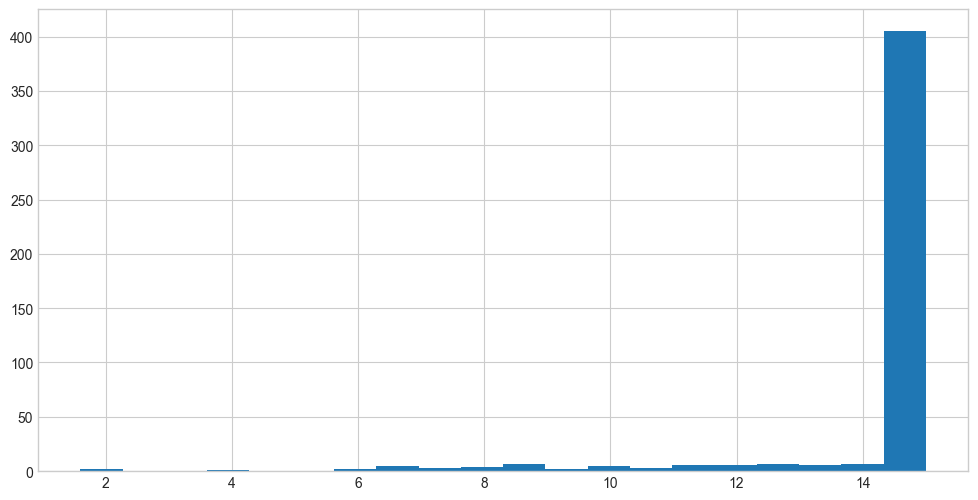

In [19]:
ticker_stats["years_data"].hist(bins=20);


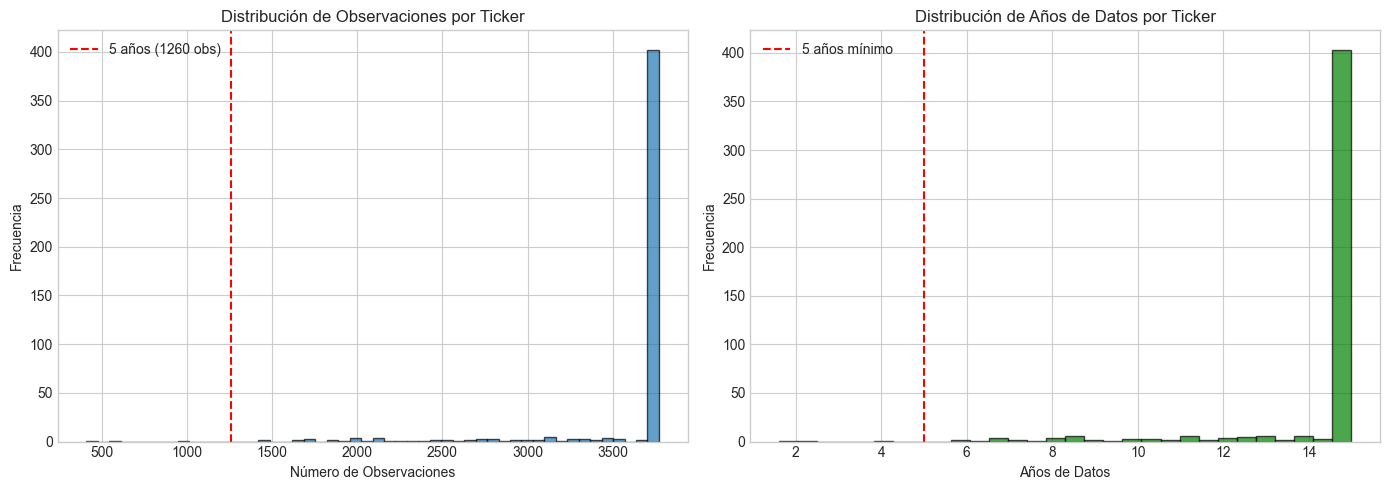


✅ Figura guardada en: c:\Users\carlo\Documents\4.DS\riskmanagement2025\reports\figures\01_data_distribution.png


In [20]:
# ================================================
# Visualización: Distribución de observaciones
# ================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de observaciones por ticker
axes[0].hist(ticker_stats['obs_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=252*5, color='red', linestyle='--', label='5 años (1260 obs)')
axes[0].set_xlabel('Número de Observaciones')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Observaciones por Ticker')
axes[0].legend()

# Histograma de años de datos
axes[1].hist(ticker_stats['years_data'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=5, color='red', linestyle='--', label='5 años mínimo')
axes[1].set_xlabel('Años de Datos')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Años de Datos por Ticker')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_PATH / '01_data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: {FIGURES_PATH / '01_data_distribution.png'}")

## 5. Filtrado de Activos con Datos Suficientes

In [21]:
# ================================================
# Definir criterios de filtrado
# ================================================
MIN_YEARS = 5  # Mínimo de años de datos
MIN_OBSERVATIONS = 252 * MIN_YEARS  # ~1260 observaciones (días de trading)

print(f"📋 Criterios de filtrado:")
print(f"   • Mínimo de años: {MIN_YEARS}")
print(f"   • Mínimo de observaciones: {MIN_OBSERVATIONS:,}")

📋 Criterios de filtrado:
   • Mínimo de años: 5
   • Mínimo de observaciones: 1,260


In [22]:
# ================================================
# Filtrar tickers válidos
# ================================================
# Tickers con suficientes observaciones
valid_tickers = ticker_stats[ticker_stats['obs_count'] >= MIN_OBSERVATIONS].index.tolist()

print(f"\n📊 Resultados del filtrado:")
print(f"   • Tickers totales: {len(ticker_stats):,}")
print(f"   • Tickers válidos (≥{MIN_YEARS} años): {len(valid_tickers):,}")
print(f"   • Tickers excluidos: {len(ticker_stats) - len(valid_tickers):,}")
print(f"   • Porcentaje conservado: {len(valid_tickers)/len(ticker_stats)*100:.1f}%")


📊 Resultados del filtrado:
   • Tickers totales: 471
   • Tickers válidos (≥5 años): 468
   • Tickers excluidos: 3
   • Porcentaje conservado: 99.4%


In [23]:
# ================================================
# Mostrar algunos tickers válidos
# ================================================
print(f"\n📋 Primeros 30 tickers válidos:")
print("=" * 60)
for i, ticker in enumerate(sorted(valid_tickers)[:30], 1):
    obs = ticker_stats.loc[ticker, 'obs_count']
    years = ticker_stats.loc[ticker, 'years_data']
    print(f"  {i:3}. {ticker:<8} | {obs:,} obs | {years:.1f} años")


📋 Primeros 30 tickers válidos:
    1. A        | 3,770 obs | 15.0 años
    2. AAL      | 3,027 obs | 12.0 años
    3. AAP      | 3,770 obs | 15.0 años
    4. AAPL     | 3,770 obs | 15.0 años
    5. ABBV     | 3,278 obs | 13.0 años
    6. ABT      | 3,770 obs | 15.0 años
    7. ACN      | 3,770 obs | 15.0 años
    8. ADBE     | 3,770 obs | 15.0 años
    9. ADI      | 3,451 obs | 13.7 años
   10. ADM      | 3,770 obs | 15.0 años
   11. ADP      | 3,770 obs | 15.0 años
   12. AEE      | 3,770 obs | 15.0 años
   13. AEP      | 3,771 obs | 15.0 años
   14. AES      | 3,770 obs | 15.0 años
   15. AFL      | 3,770 obs | 15.0 años
   16. AGG      | 3,770 obs | 15.0 años
   17. AIG      | 3,770 obs | 15.0 años
   18. AIZ      | 3,770 obs | 15.0 años
   19. AJG      | 3,770 obs | 15.0 años
   20. AKAM     | 3,770 obs | 15.0 años
   21. ALB      | 3,770 obs | 15.0 años
   22. ALGN     | 3,770 obs | 15.0 años
   23. ALK      | 3,770 obs | 15.0 años
   24. ALL      | 3,770 obs | 15.0 años
   25. A

## 6. Verificación del Benchmark SPY

In [24]:
# ================================================
# Verificar disponibilidad de SPY
# ================================================
BENCHMARK = 'SPY'

print(f"🔍 Verificación del Benchmark: {BENCHMARK}")
print("=" * 60)

if BENCHMARK in valid_tickers:
    spy_stats = ticker_stats.loc[BENCHMARK]
    print(f"\n✅ {BENCHMARK} ENCONTRADO en tickers válidos")
    print(f"\n📊 Estadísticas de {BENCHMARK}:")
    print(f"   • Observaciones: {spy_stats['obs_count']:,.0f}")
    print(f"   • Primera fecha: {spy_stats['first_date']}")
    print(f"   • Última fecha: {spy_stats['last_date']}")
    print(f"   • Años de datos: {spy_stats['years_data']:.1f}")
    print(f"   • Precio promedio: ${spy_stats['price_mean']:.2f}")
    print(f"   • Precio mínimo: ${spy_stats['price_min']:.2f}")
    print(f"   • Precio máximo: ${spy_stats['price_max']:.2f}")
elif BENCHMARK in ticker_stats.index:
    print(f"\n⚠️ {BENCHMARK} existe pero NO cumple criterios mínimos")
    print(f"   Observaciones: {ticker_stats.loc[BENCHMARK, 'obs_count']:,.0f}")
else:
    print(f"\n❌ {BENCHMARK} NO encontrado en los datos")
    print("   Considera usar otro benchmark o verificar los datos.")

🔍 Verificación del Benchmark: SPY

✅ SPY ENCONTRADO en tickers válidos

📊 Estadísticas de SPY:
   • Observaciones: 3,770
   • Primera fecha: 2010-12-27 00:00:00
   • Última fecha: 2025-12-19 00:00:00
   • Años de datos: 15.0
   • Precio promedio: $305.15
   • Precio mínimo: $109.93
   • Precio máximo: $689.17


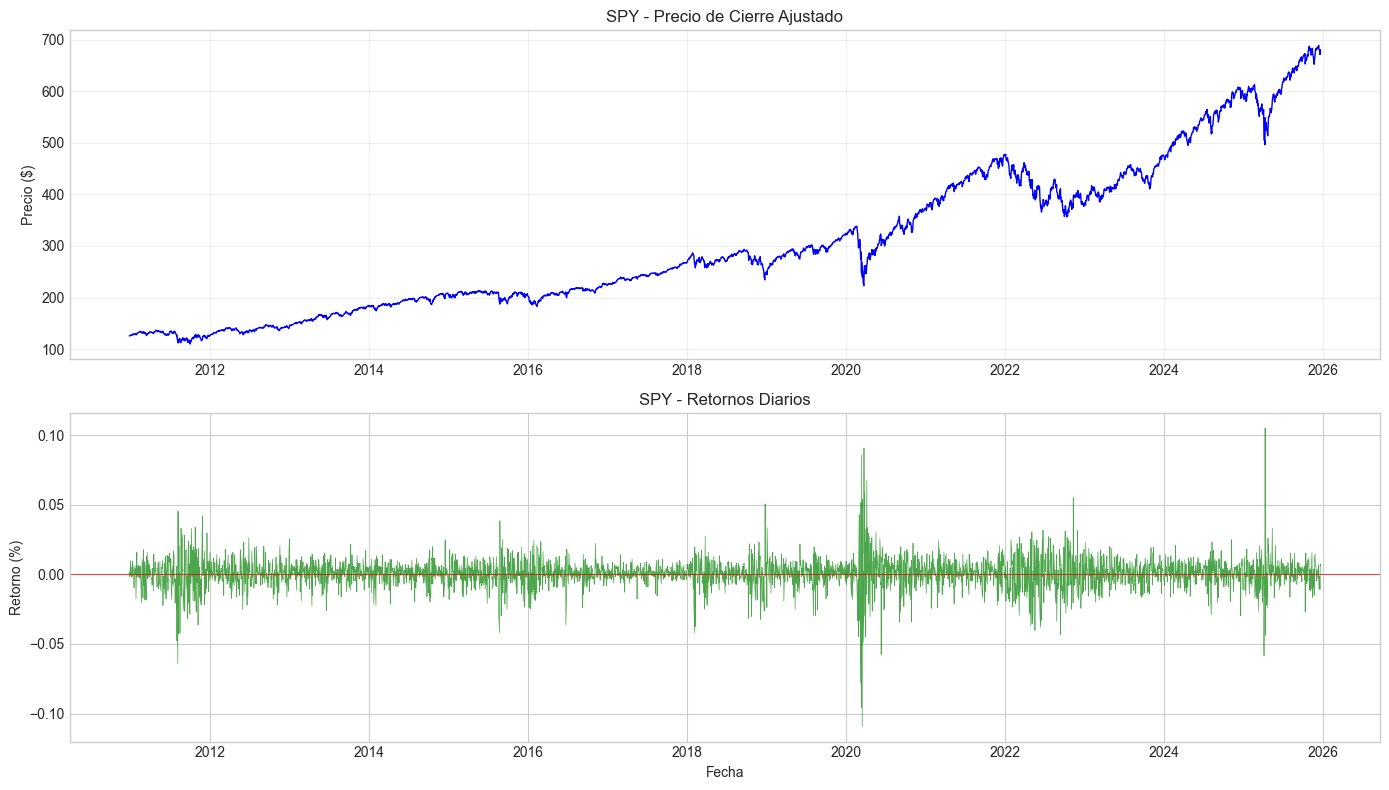


✅ Figura guardada en: c:\Users\carlo\Documents\4.DS\riskmanagement2025\reports\figures\01_spy_benchmark.png


In [25]:
# ================================================
# Visualizar serie de precios de SPY
# ================================================
if BENCHMARK in df_prices[TICKER_COL].values:
    spy_data = df_prices[df_prices[TICKER_COL] == BENCHMARK].copy()
    spy_data = spy_data.set_index(DATE_COL)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Precio
    axes[0].plot(spy_data.index, spy_data[PRICE_COL], linewidth=1, color='blue')
    axes[0].set_title(f'{BENCHMARK} - Precio de Cierre Ajustado', fontsize=12)
    axes[0].set_ylabel('Precio ($)')
    axes[0].grid(True, alpha=0.3)
    
    # Retornos diarios
    spy_returns = spy_data[PRICE_COL].pct_change()
    axes[1].plot(spy_data.index, spy_returns, linewidth=0.5, color='green', alpha=0.7)
    axes[1].axhline(y=0, color='red', linestyle='-', linewidth=0.5)
    axes[1].set_title(f'{BENCHMARK} - Retornos Diarios', fontsize=12)
    axes[1].set_ylabel('Retorno (%)')
    axes[1].set_xlabel('Fecha')
    
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / '01_spy_benchmark.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Figura guardada en: {FIGURES_PATH / '01_spy_benchmark.png'}")

## 7. Exportación de Tickers Válidos

In [26]:
# ================================================
# Guardar lista de tickers válidos
# ================================================
valid_tickers_df = pd.DataFrame({
    'ticker': valid_tickers,
    'observations': [ticker_stats.loc[t, 'obs_count'] for t in valid_tickers],
    'years_data': [ticker_stats.loc[t, 'years_data'] for t in valid_tickers],
    'first_date': [ticker_stats.loc[t, 'first_date'] for t in valid_tickers],
    'last_date': [ticker_stats.loc[t, 'last_date'] for t in valid_tickers]
})

# Ordenar por ticker
valid_tickers_df = valid_tickers_df.sort_values('ticker').reset_index(drop=True)

# Guardar
output_path = REPORTS_PATH / 'valid_tickers.csv'
valid_tickers_df.to_csv(output_path, index=False)

print(f"✅ Lista de tickers válidos guardada en: {output_path}")
print(f"\n📊 Resumen:")
print(f"   • Total tickers: {len(valid_tickers_df)}")
print(f"   • Benchmark incluido: {BENCHMARK in valid_tickers}")

display(valid_tickers_df.head(10))

✅ Lista de tickers válidos guardada en: c:\Users\carlo\Documents\4.DS\riskmanagement2025\reports\valid_tickers.csv

📊 Resumen:
   • Total tickers: 468
   • Benchmark incluido: True


,ticker,observations,years_data,first_date,last_date
0,A,3770,15.0000,2010-12-27,2025-12-19
1,AAL,3027,12.0000,2013-12-09,2025-12-19
2,AAP,3770,15.0000,2010-12-27,2025-12-19
3,AAPL,3770,15.0000,2010-12-27,2025-12-19
4,ABBV,3278,13.0000,2012-12-10,2025-12-19
5,ABT,3770,15.0000,2010-12-27,2025-12-19
6,ACN,3770,15.0000,2010-12-27,2025-12-19
7,ADBE,3770,15.0000,2010-12-27,2025-12-19
8,ADI,3451,13.7000,2012-04-02,2025-12-19
9,ADM,3770,15.0000,2010-12-27,2025-12-19


## 8. Construcción de Matriz de Activos (Pivot)

In [27]:
# ================================================
# Filtrar datos solo de tickers válidos
# ================================================
print("⏳ Filtrando datos de tickers válidos...")

df_valid = df_prices[df_prices[TICKER_COL].isin(valid_tickers)].copy()

print(f"\n📊 Datos filtrados:")
print(f"   • Registros originales: {len(df_prices):,}")
print(f"   • Registros filtrados: {len(df_valid):,}")
print(f"   • Tickers incluidos: {df_valid[TICKER_COL].nunique()}")

⏳ Filtrando datos de tickers válidos...

📊 Datos filtrados:
   • Registros originales: 1,694,523
   • Registros filtrados: 1,692,568
   • Tickers incluidos: 468


In [28]:
# ================================================
# Crear Matriz de Activos (Precio Ajustado)
# Filas: Fechas | Columnas: Tickers
# ================================================
print("⏳ Construyendo matriz de activos (precios)...")

# Pivot: fechas como índice, tickers como columnas
prices_matrix = df_valid.pivot(
    index=DATE_COL, 
    columns=TICKER_COL, 
    values=PRICE_COL
)

# Ordenar por fecha
prices_matrix = prices_matrix.sort_index()

print(f"\n✅ Matriz de precios creada")
print(f"   📊 Dimensiones: {prices_matrix.shape[0]:,} fechas x {prices_matrix.shape[1]} activos")
print(f"   📅 Rango: {prices_matrix.index.min()} → {prices_matrix.index.max()}")

# Mostrar muestra
print(f"\n📋 Muestra de la matriz (primeras 5 filas, primeros 8 activos):")
display(prices_matrix.iloc[:5, :8])

⏳ Construyendo matriz de activos (precios)...

✅ Matriz de precios creada
   📊 Dimensiones: 3,771 fechas x 468 activos
   📅 Rango: 2010-12-23 00:00:00 → 2025-12-19 00:00:00

📋 Muestra de la matriz (primeras 5 filas, primeros 8 activos):


symbol,A,AAL,AAP,AAPL,ABBV,ABT,ACN,ADBE
date,,,,,,,,
2010-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-27,41.9200,NaN,66.4200,11.6000,NaN,22.6700,48.2500,30.9500
2010-12-28,41.5100,NaN,66.2500,11.6200,NaN,22.6800,47.9800,30.9200
2010-12-29,41.6900,NaN,66.4500,11.6200,NaN,22.6900,48.6200,30.9700
2010-12-30,41.5900,NaN,66.7200,11.5600,NaN,22.7600,48.4200,30.5700


In [29]:
# ================================================
# Análisis de valores faltantes en la matriz
# ================================================
print("📊 Análisis de Valores Faltantes en Matriz:")
print("=" * 60)

null_per_ticker = prices_matrix.isnull().sum()
null_per_date = prices_matrix.isnull().sum(axis=1)

print(f"\n📋 Por Ticker:")
print(f"   • Tickers con cero nulos: {(null_per_ticker == 0).sum()}")
print(f"   • Tickers con algunos nulos: {(null_per_ticker > 0).sum()}")
print(f"   • Máximo nulos en un ticker: {null_per_ticker.max()}")

print(f"\n📋 Por Fecha:")
print(f"   • Fechas completas (todos los activos): {(null_per_date == 0).sum()}")
print(f"   • Fechas con algunos nulos: {(null_per_date > 0).sum()}")

# Porcentaje total de nulos
total_cells = prices_matrix.shape[0] * prices_matrix.shape[1]
total_nulls = prices_matrix.isnull().sum().sum()
print(f"\n📊 Resumen:")
print(f"   • Celdas totales: {total_cells:,}")
print(f"   • Celdas nulas: {total_nulls:,}")
print(f"   • Porcentaje nulos: {total_nulls/total_cells*100:.2f}%")

📊 Análisis de Valores Faltantes en Matriz:

📋 Por Ticker:
   • Tickers con cero nulos: 68
   • Tickers con algunos nulos: 400
   • Máximo nulos en un ticker: 2323

📋 Por Fecha:
   • Fechas completas (todos los activos): 1433
   • Fechas con algunos nulos: 2338

📊 Resumen:
   • Celdas totales: 1,764,828
   • Celdas nulas: 72,260
   • Porcentaje nulos: 4.09%


In [ ]:
# ================================================
# Resumen de nulos en matriz de precios
# PORREVISAREL27
# ================================================
print("📊 RESUMEN DE VALORES NULOS EN MATRIZ DE PRECIOS")
print("=" * 60)

# Calcular métricas
total_celdas = prices_matrix.shape[0] * prices_matrix.shape[1]
total_nulos = prices_matrix.isnull().sum().sum()
porcentaje_nulos = (total_nulos / total_celdas) * 100

print(f"\n📋 Dimensiones de la matriz:")
print(f"   • Filas (fechas): {prices_matrix.shape[0]:,}")
print(f"   • Columnas (activos): {prices_matrix.shape[1]:,}")
print(f"   • Total celdas: {total_celdas:,}")

print(f"\n📊 Valores Nulos:")
print(f"   • Cantidad de nulos: {total_nulos:,}")
print(f"   • Porcentaje de nulos: {porcentaje_nulos:.4f}%")
print(f"   • Celdas con datos: {total_celdas - total_nulos:,} ({100 - porcentaje_nulos:.4f}%)")

In [ ]:
# ================================================
# Manejar valores faltantes (forward fill)
# ================================================
print("⏳ Aplicando forward fill para valores faltantes...")

# Forward fill (usar último precio conocido)
prices_matrix_filled = prices_matrix.ffill()

# Eliminar filas iniciales que aún tengan NaN (no hay precio previo)
prices_matrix_filled = prices_matrix_filled.dropna()

print(f"\n✅ Matriz procesada:")
print(f"   • Dimensiones finales: {prices_matrix_filled.shape[0]:,} fechas x {prices_matrix_filled.shape[1]} activos")
print(f"   • Valores nulos restantes: {prices_matrix_filled.isnull().sum().sum()}")

In [ ]:
# ================================================
# Guardar matriz de precios
# ================================================
output_path_prices = REPORTS_PATH / 'prices_matrix.csv'
prices_matrix_filled.to_csv(output_path_prices)

print(f"✅ Matriz de precios guardada en: {output_path_prices}")
print(f"   📊 Tamaño del archivo: {output_path_prices.stat().st_size / (1024*1024):.2f} MB")

In [ ]:
# ================================================
# Crear y guardar matriz de retornos diarios
# ================================================
print("⏳ Calculando matriz de retornos diarios...")

returns_matrix = prices_matrix_filled.pct_change().dropna()

print(f"\n✅ Matriz de retornos creada:")
print(f"   📊 Dimensiones: {returns_matrix.shape[0]:,} fechas x {returns_matrix.shape[1]} activos")

# Guardar
output_path_returns = REPORTS_PATH / 'returns_matrix.csv'
returns_matrix.to_csv(output_path_returns)

print(f"\n✅ Matriz de retornos guardada en: {output_path_returns}")

# Mostrar muestra
print(f"\n📋 Muestra de retornos (primeras 5 filas, primeros 8 activos):")
display(returns_matrix.iloc[:5, :8])

## 9. Visualización Exploratoria Final

In [ ]:
# ================================================
# Heatmap de correlaciones (muestra de activos)
# ================================================
print("📊 Generando heatmap de correlaciones...")

# Seleccionar muestra de activos para visualización
sample_tickers = sorted(valid_tickers)[:20]  # Primeros 20 alfabéticamente
if BENCHMARK not in sample_tickers:
    sample_tickers = [BENCHMARK] + sample_tickers[:19]

# Calcular correlación
corr_matrix = returns_matrix[sample_tickers].corr()

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlGn', center=0, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Matriz de Correlación de Retornos (Muestra de 20 Activos)', fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_PATH / '01_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: {FIGURES_PATH / '01_correlation_heatmap.png'}")

In [ ]:
# ================================================
# Rendimiento normalizado de activos seleccionados
# ================================================
print("📊 Generando gráfico de rendimiento normalizado...")

# Seleccionar algunos activos representativos
plot_tickers = [BENCHMARK] + [t for t in valid_tickers if t != BENCHMARK][:9]  # SPY + 9 activos

# Normalizar precios (base 100)
normalized = prices_matrix_filled[plot_tickers] / prices_matrix_filled[plot_tickers].iloc[0] * 100

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
for ticker in plot_tickers:
    linewidth = 2.5 if ticker == BENCHMARK else 1
    alpha = 1.0 if ticker == BENCHMARK else 0.7
    ax.plot(normalized.index, normalized[ticker], label=ticker, linewidth=linewidth, alpha=alpha)

ax.axhline(y=100, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_title('Rendimiento Normalizado (Base 100)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor Normalizado')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '01_normalized_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: {FIGURES_PATH / '01_normalized_performance.png'}")

## 10. Resumen y Conclusiones

In [ ]:
# ================================================
# Resumen final del EDA
# ================================================
print("="*70)
print("📊 RESUMEN FINAL DEL ANÁLISIS EXPLORATORIO")
print("="*70)

print(f"""
📁 BASE DE DATOS:
   • Ruta: {DATA_PATH}
   • Tabla principal: {price_table}

📋 DATOS ORIGINALES:
   • Total registros: {len(df_prices):,}
   • Total tickers: {df_prices[TICKER_COL].nunique()}
   • Rango de fechas: {df_prices[DATE_COL].min().date()} → {df_prices[DATE_COL].max().date()}

✅ DATOS FILTRADOS (≥{MIN_YEARS} años):
   • Tickers válidos: {len(valid_tickers)}
   • Benchmark ({BENCHMARK}): {'✅ Incluido' if BENCHMARK in valid_tickers else '❌ No disponible'}

📊 MATRICES EXPORTADAS:
   • Precios: {prices_matrix_filled.shape[0]:,} fechas x {prices_matrix_filled.shape[1]} activos
   • Retornos: {returns_matrix.shape[0]:,} fechas x {returns_matrix.shape[1]} activos

📁 ARCHIVOS GENERADOS:
   • {REPORTS_PATH / 'valid_tickers.csv'}
   • {REPORTS_PATH / 'prices_matrix.csv'}
   • {REPORTS_PATH / 'returns_matrix.csv'}
   • {FIGURES_PATH / '01_data_distribution.png'}
   • {FIGURES_PATH / '01_spy_benchmark.png'}
   • {FIGURES_PATH / '01_correlation_heatmap.png'}
   • {FIGURES_PATH / '01_normalized_performance.png'}
""")

print("="*70)
print("✅ Notebook 01 completado. Continuar con Notebook 02: Feature Engineering")
print("="*70)

In [ ]:
# ================================================
# Cerrar conexión a base de datos
# ================================================
conn.close()
print("✅ Conexión a base de datos cerrada.")